Steane code logical operation with software decoding
============================================

In this workbook logical operations for the Steane code are compared with the equivalent operations for a single qubit.  The workbook is set up without transpilation and iterates through a number of scaling error factors.

1. Set up logical zero for Steane code based  on the parity matrix in the book by Nielsen MA, Chuang IL. Quantum Computation and Quantum Information, 10th Anniversary Edition. Cambridge University Press; 2016. p. 474 

2. Set up physical Hadamard, CX and X to produce a physical Bell pair.

2. Set up logical Hadamard, CX and X to produce a logical Bell pair.

3. Set up the ancilla for the logical qubits

4. Attempt to correct the logical data qubits using decoding software.

5. Assess how many data qubits would give a valid logical Bell state and compare to the physical qubits.

6. Repeat for different noise scaling factors.

Import the necessary function modules, including the SteaneCodeLogicalQubit class and helper functions.

In [1]:
from qiskit import(
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
    execute,
    Aer
    )

from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit.compiler import transpile

from circuits import SteaneCodeLogicalQubit

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from helper_functions import (
    count_valid_output_strings,
    find_individual_ancilla_values,
    find_ancilla_values,
    find_parity,
    get_noise,
    summarise_logical_counts,
    mean_of_list,
    calculate_standard_error,
    flip_code_words, 
    correct_qubit,
    convert_codewords,
    look_up_data
    )

Define constants so that the process flow can be controlled from one place:

In [2]:
DATA_QUBITS = 7
ANCILLA_QUBITS = 3
SPACE = ' '
FACTOR_LIST = [1, 0.1, 0.01, 0.001, 0.0001]
TITLE1 = 'Bell pair fidelity in logical and physical qubits '

#use standard gate set without transpilation
SINGLE_GATE_SET  = ['id', 'x', 'y', 'z', 'h']
TWO_GATE_SET = ['cx', 'cz']

NOISE = True                            #Test with noise
SHOTS = 100000                          #Number of shots to run    
MEASURE_NOISE = 0.0046                  #Measurement noise
SINGLE_GATE_DEPOLARISING = 0.000366     #Single gate noise   
TWO_GATE_DEPOLARISING = 0.0204          #Two gate noise 
ITERATIONS = 25

SIMULATOR = Aer.get_backend('qasm_simulator')

Specify the parity check matrix, since this defines the Steane code.  It is validated before the logical qubit is initiated to check that it is orthogonal to the valid codewords.

In [3]:
parity_check_matrix = [[0,0,0,1,1,1,1],
                       [0,1,1,0,0,1,1],
                       [1,0,1,0,1,0,1]]

The allowed codewords for the logical zero from Nielsen and Chuang is stored in a list.  Note, the order of qubits in the list is reversed compared to the normal output of Qiskit.

In [4]:
codewords = [[0,0,0,0,0,0,0],   
             [1,0,1,0,1,0,1],
             [0,1,1,0,0,1,1],
             [1,1,0,0,1,1,0],
             [0,0,0,1,1,1,1],
             [1,0,1,1,0,1,0],
             [0,1,1,1,1,0,0],
             [1,1,0,1,0,0,1]]

In [5]:
#carryout a bit flip of the list of codewords to find the codewords for the logical one.
flipped_codewords = flip_code_words(codewords)

In [6]:
#The allowed codewords for a single qubit Bell pair
bell_valid_codewords = [[0,1],[1,0]]

In [7]:
#function to print time
def print_time():
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Current Time =", current_time)
    return

Physical qubits circuit for Bell pair
-------------------------------------------------

Function module to set up a Bell pair with two physical qubits.

In [8]:
def execute_physical_qubits(measure_noise, single_gate_depolarising, two_gate_depolarising):
    print()
    print('Physical qubits Bell pair')
    error_rate_list = []
    for iteration in range(ITERATIONS):
        #print(f'For iteration {iteration}')
        qr = QuantumRegister(2,'code_qubit')     # Two code QBits
        cr = ClassicalRegister(2,'syndrome_bit') # Two registers
        qc = QuantumCircuit(qr, cr)
        qc.h(qr[0])
        qc.x(qr[1])
        qc.cx(qr[0],qr[1])
        qc.measure(qr, cr)
        #initialise circuit
        if NOISE:
            noise_model = get_noise(measure_noise, single_gate_depolarising, 
                                    two_gate_depolarising, SINGLE_GATE_SET , TWO_GATE_SET
                                   )
        if NOISE:
            result = execute(qc, SIMULATOR, noise_model = noise_model, shots = SHOTS).result()
        else:
            result = execute(qc, SIMULATOR, shots = SHOTS).result()
        counts = result.get_counts(qc)
        count_valid, count_invalid = count_valid_output_strings(counts, bell_valid_codewords, 0)
        #print(f'The results are {counts}')
        #print(f'Valid codewords {bell_valid_codewords}')      
        error_rate = count_invalid / SHOTS
        #print(f'The error rate is {error_rate:.4f}')
        #print()
        error_rate_list.append(error_rate)
    mean_error_physical = mean_of_list(error_rate_list)
    standard_deviation_physical, standard_error_physical = calculate_standard_error(error_rate_list)
    print(f'The mean error rate is {mean_error_physical:.8f} and the standard error is {standard_error_physical:.8f}')
    return(mean_error_physical, standard_error_physical)

Logical Bell pair
-----------------------

Function module to set up the Bell pair with two logical qubits.

In [9]:
def set_up_circuit():
    qubit = SteaneCodeLogicalQubit(2, parity_check_matrix, codewords, False)
    for index in range(2):
        qubit.set_up_logical_zero(index)
    qubit.barrier()
    qubit.logical_gate_H(0)
    qubit.logical_gate_X(1)    
    qubit.logical_gate_CX(0, 1)
    qubit.force_X_error(1, 0)
    qubit.force_X_error(5, 1)
    qubit.barrier()
    for index in range(2):
        qubit.set_up_ancilla(index)
        qubit.barrier()
        qubit.logical_measure(index)
    return(qubit)

Function module to execute the logical Bell pair.  For items in the counts dictionary the data qubits are corrected based on the ancilla measurements.  Each data qubit measurements is then decoded to:
 - 0 if the bit string is in the set of logical zero bitstring
 - 1 if the bit string is in the set of logical one bitstring
 - 2 if the bitstring is outside the codespace of valid bitstrings

A check is made to find out if the string of two bits after decoding is in the set of valid bell pairs {'01' and '10'}
Finally the results of the calculation are summarised and returned.

In [10]:
def execute_logical_qubits(measure_noise, single_gate_depolarising, two_gate_depolarising):
    print()
    print('Logical qubits Bell pair')
    corrected_key =''
    invalid_list = []
    valid_list = []
    for iteration in range(ITERATIONS):
        corrected_counts = {}
        new_counts = {}
        qubit = set_up_circuit()
        if NOISE:
                noise_model = get_noise(measure_noise, single_gate_depolarising, 
                                        two_gate_depolarising, SINGLE_GATE_SET , TWO_GATE_SET
                                       )
                result = execute(qubit, SIMULATOR, noise_model = noise_model, shots = SHOTS).result()
        else:
                result = execute(qubit, SIMULATOR, shots = SHOTS).result()
        counts = result.get_counts(qubit)
        corrected_data = []
        for key, values in counts.items():
            #print('key, values', key, values)
            # X ancilla1
            key0 = key.split()[0]
            # Z ancilla1
            key1 = key.split()[1]
            #data qubits1
            key2 = key.split()[2]
            # X ancilla2
            key3 = key.split()[3]
            # Z ancilla2
            key4 = key.split()[4]
            #data qubits2
            key5 = key.split()[5]
            corrected_data0 = correct_qubit(key2, key0, DATA_QUBITS)
            corrected_data1 = correct_qubit(key5, key3, DATA_QUBITS)
            corrected_key = key0 + SPACE + key1 + SPACE + corrected_data0 + SPACE
            corrected_key = corrected_key + key3 + SPACE + key4 + SPACE + corrected_data1
            value_found = corrected_counts.get(corrected_key)
            if value_found:
                corrected_counts[corrected_key] = value_found + values
            else:
                corrected_counts.update({corrected_key: values})  
        new_counts = summarise_logical_counts(corrected_counts, codewords, flipped_codewords, 2, 5)  
        count_valid, count_invalid = count_valid_output_strings(new_counts, bell_valid_codewords, 0)
        invalid_list.append(count_invalid)
        valid_list.append(count_valid)
    mean_invalid = mean_of_list(invalid_list)
    total_valid = sum(valid_list)
    total_invalid = sum(invalid_list)
    total_all = total_valid + total_invalid
    print(f'There were {total_valid} valid shots and {total_invalid} invalid shots giving {total_all} in total')
    mean_error_logical = mean_invalid / SHOTS
    standard_deviation, standard_error = calculate_standard_error(invalid_list)
    standard_error_logical = standard_error / SHOTS
    print(f'On average there are {mean_invalid:.1f} invalid codewords with a standard error of {standard_error:.1f}')
    print(f'The mean error rate for a single qubit is {mean_error_logical :.8f} and the standard error is {standard_error_logical:.8f}')
    return(mean_error_logical, standard_error_logical)

Function for plotting graph

In [11]:
def plot_graph(title, factor_list, physical_list, logical_list, physical_error_list, logical_error_list):
    plt.plot(factor_list, physical_list, '.',color = '#ff8333',linestyle = '', label = 'Physical Qubits')
    plt.plot(factor_list, logical_list, '.',color = '#8333ff', linestyle = '',label = 'Logical Qubits')
    plt.errorbar(factor_list, physical_list, yerr = physical_error_list, color = '#ff8333' )
    plt.errorbar(factor_list, logical_list, yerr = logical_error_list, color = '#8333ff' )
    plt.xlabel('Error scaling factor')
    plt.ylabel('Error rate')
    plt.title(title, fontsize = '8')
    plt.xscale("log")
    plt.yscale("log")
    plt.legend(fontsize = '8')
    fname = title + '.png'
    plt.savefig(title)

Iterate through different noise scaling factor for physical and logical Bell pairs and append results to lists used for graphs.  There different noise scenarios are considered in turn because the simulations might take a long time to run.

Running with normal noise

Processing error scaling factor 1
Current Time = 14:28:10

Physical qubits Bell pair
The mean error rate is 0.02920280 and the standard error is 0.00008431

Logical qubits Bell pair
There were 894985 valid shots and 1605015 invalid shots giving 2500000 in total
On average there are 64200.6 invalid codewords with a standard error of 28.1
The mean error rate for a single qubit is 0.64200600 and the standard error is 0.00028134

Processing error scaling factor 0.1
Current Time = 14:39:14

Physical qubits Bell pair
The mean error rate is 0.00297240 and the standard error is 0.00003691

Logical qubits Bell pair
There were 2213174 valid shots and 286826 invalid shots giving 2500000 in total
On average there are 11473.0 invalid codewords with a standard error of 24.1
The mean error rate for a single qubit is 0.11473040 and the standard error is 0.00024128

Processing error scaling factor 0.01
Current Time = 14:50:49

Physical qubits Bell pair
The mean error rate is 

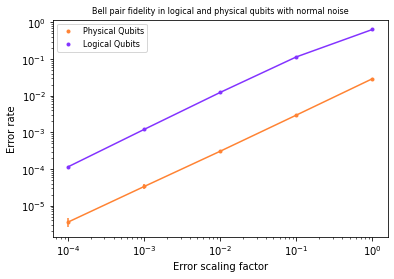

In [12]:
physical_list = []
logical_list = []
physical_error_list = []
logical_error_list = []
title2 = 'with normal noise'
print('Running with normal noise')
for factor in FACTOR_LIST:
    print()
    print(f'Processing error scaling factor {factor}')
    print_time()
    measure_noise = MEASURE_NOISE * factor
    single_gate_depolarising = SINGLE_GATE_DEPOLARISING * factor
    two_gate_depolarising = TWO_GATE_DEPOLARISING * factor
    
    mean_error, standard_error = execute_physical_qubits(measure_noise, single_gate_depolarising, two_gate_depolarising)
    physical_list.append(mean_error)
    physical_error_list.append(standard_error)
    
    mean_error, standard_error = execute_logical_qubits(measure_noise, single_gate_depolarising, two_gate_depolarising)
    logical_list.append(mean_error)
    logical_error_list.append(standard_error)
title = TITLE1 + title2
plot_graph(title, FACTOR_LIST, physical_list, logical_list, physical_error_list, logical_error_list)

Running without measure noise
Processing error scaling factor 1
Current Time = 15:25:40

Physical qubits Bell pair
The mean error rate is 0.02029800 and the standard error is 0.00007975

Logical qubits Bell pair
There were 976951 valid shots and 1523049 invalid shots giving 2500000 in total
On average there are 60922.0 invalid codewords with a standard error of 24.0
The mean error rate for a single qubit is 0.60921960 and the standard error is 0.00023957
Processing error scaling factor 0.1
Current Time = 15:37:43

Physical qubits Bell pair
The mean error rate is 0.00208520 and the standard error is 0.00003112

Logical qubits Bell pair
There were 2233947 valid shots and 266053 invalid shots giving 2500000 in total
On average there are 10642.1 invalid codewords with a standard error of 21.9
The mean error rate for a single qubit is 0.10642120 and the standard error is 0.00021911
Processing error scaling factor 0.01
Current Time = 15:49:22

Physical qubits Bell pair
The mean error rate is

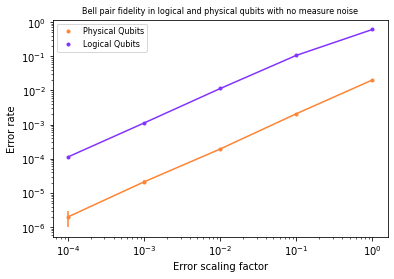

In [13]:
physical_list = []
logical_list = []
physical_error_list = []
logical_error_list = []
title2 = 'with no measure noise'
print('Running without measure noise')
for factor in FACTOR_LIST:
    print(f'Processing error scaling factor {factor}')
    print_time()
    measure_noise = 0
    single_gate_depolarising = SINGLE_GATE_DEPOLARISING * factor
    two_gate_depolarising = TWO_GATE_DEPOLARISING * factor
    
    mean_error, standard_error = execute_physical_qubits(measure_noise, single_gate_depolarising, two_gate_depolarising)
    physical_list.append(mean_error)
    physical_error_list.append(standard_error)
    
    mean_error, standard_error = execute_logical_qubits(measure_noise, single_gate_depolarising, two_gate_depolarising)
    logical_list.append(mean_error)
    logical_error_list.append(standard_error)
title = TITLE1 + title2
plot_graph(title, FACTOR_LIST, physical_list, logical_list, physical_error_list, logical_error_list)

Running with single and two gate noises same
Processing error scaling factor 1
Current Time = 16:23:07

Physical qubits Bell pair
The mean error rate is 0.02042560 and the standard error is 0.00009927

Logical qubits Bell pair
There were 977100 valid shots and 1522900 invalid shots giving 2500000 in total
On average there are 60916.0 invalid codewords with a standard error of 34.5
The mean error rate for a single qubit is 0.60916000 and the standard error is 0.00034529
Processing error scaling factor 0.1
Current Time = 16:35:14

Physical qubits Bell pair
The mean error rate is 0.00205960 and the standard error is 0.00003169

Logical qubits Bell pair
There were 2233644 valid shots and 266356 invalid shots giving 2500000 in total
On average there are 10654.2 invalid codewords with a standard error of 20.5
The mean error rate for a single qubit is 0.10654240 and the standard error is 0.00020531
Processing error scaling factor 0.01
Current Time = 16:47:13

Physical qubits Bell pair
The mea

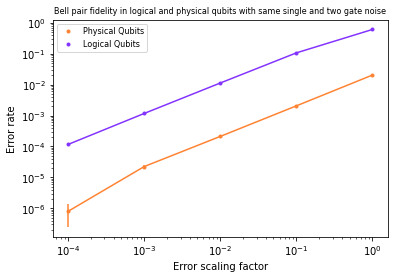

In [14]:
physical_list = []
logical_list = []
physical_error_list = []
logical_error_list = []
title2 = 'with same single and two gate noise'
print('Running with single and two gate noises same')
for factor in FACTOR_LIST:
    print(f'Processing error scaling factor {factor}')
    print_time()
    measure_noise = 0
    single_gate_depolarising = SINGLE_GATE_DEPOLARISING * factor
    two_gate_depolarising = TWO_GATE_DEPOLARISING * factor
    
    mean_error, standard_error = execute_physical_qubits(measure_noise, single_gate_depolarising, two_gate_depolarising)
    physical_list.append(mean_error)
    physical_error_list.append(standard_error)
    
    mean_error, standard_error = execute_logical_qubits(measure_noise, single_gate_depolarising, two_gate_depolarising)
    logical_list.append(mean_error)
    logical_error_list.append(standard_error)
title = TITLE1 + title2
plot_graph(title, FACTOR_LIST, physical_list, logical_list, physical_error_list, logical_error_list)